In [1]:
# 数据预处理
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

print(device)

cuda


In [2]:
# 读取数据
from utils.label_index_convert import LabelIndexConvert
from dataset import DogDataset

current_path = os.getcwd()

label_index_convert = LabelIndexConvert(current_path)

transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 所有训练数据
full_train_dataset = DogDataset(root_path=current_path,
                                transform=transform,
                                mode='train',
                                label_index_convert=label_index_convert)
# 读取测试数据
test_dataset = DogDataset(root_path=current_path,
                          transform=transform,
                          mode='test',
                          label_index_convert=label_index_convert)
# for step,(x,y) in enumerate(test_dataset):
#     print(x,y)
#     print(x.shape)
#     plt.imshow(x.permute(1,2,0))
#     break

In [3]:
# 将训练数据分为训练集和验证集
all_train_count = len(full_train_dataset)
train_rate = 0.9
train_size = int(all_train_count * train_rate)
val_size = all_train_count - train_size
print('all_train_count:', all_train_count)
print('train_size:', train_size)
print('val_size:', val_size)
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

all_train_count: 10222
train_size: 9199
val_size: 1023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 416, 416])


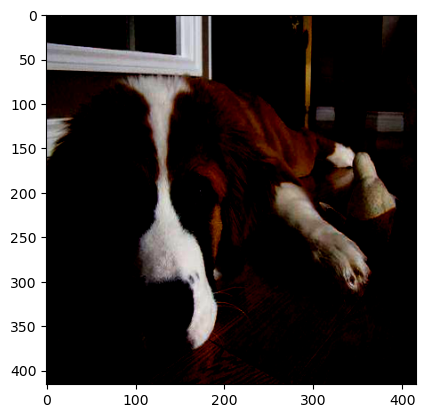

saint_bernard


In [4]:
# 输出图片
for step, (x, y) in enumerate(train_dataset):
    print(x.shape)
    plt.imshow(x.permute(1, 2, 0))
    plt.show()
    print(label_index_convert.index_to_label[y.item()])
    break

In [5]:
# 使用dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
# 训练函数  验证函数
def train(model, train_loader, val_loader, optimizer, loss_func, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        with tqdm(total=len(train_loader)) as pbar:
            for step, (x, y) in enumerate(train_loader):
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                loss = loss_func(y_pred, y)
                avg_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.set_description('epoch %d' % epoch)
                pbar.set_postfix(steps=step, loss=loss.item())
                pbar.update(1)
        print('epoch %d avg_loss:' % epoch, avg_loss / len(train_loader))
        val(model, train_loader, epoch, mode='train')
        val(model, val_dataloader, epoch, mode='val')


def val(model, val_dataloader, epoch, mode='val'):
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_count = 0
        for step, (x, y) in enumerate(val_dataloader):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)
            total_correct += torch.sum(y_pred == y).item()
            total_count += len(y)
        print(mode + ' val acc:', total_correct / total_count)


# 预测函数
def predict(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        result = []
        for step, (x, y) in enumerate(test_dataloader):
            x = x.to(device)
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)
            result.extend(y_pred.cpu().numpy())
    return result

In [7]:
# 训练模型
from model.FirstModel import FirstModel
from model.common.yolov3backbone import V3Backbone
from torch import optim
from torch import nn

model = V3Backbone()
model = model.to(device)
summary(model, (3, 416, 416))
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

train(model, train_dataloader, val_dataloader, optimizer, loss_func, epochs=15)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
              SiLU-3         [-1, 32, 416, 416]               0
              SiLU-4         [-1, 32, 416, 416]               0
              SiLU-5         [-1, 32, 416, 416]               0
              SiLU-6         [-1, 32, 416, 416]               0
              SiLU-7         [-1, 32, 416, 416]               0
              SiLU-8         [-1, 32, 416, 416]               0
              SiLU-9         [-1, 32, 416, 416]               0
             SiLU-10         [-1, 32, 416, 416]               0
             SiLU-11         [-1, 32, 416, 416]               0
             SiLU-12         [-1, 32, 416, 416]               0
             SiLU-13         [-1, 32, 416, 416]               0
             SiLU-14         [-1, 32, 4

epoch 0: 100%|██████████| 144/144 [02:40<00:00,  1.12s/it, loss=10.9, steps=143]


epoch 0 avg_loss: 27.074173639218014
train val acc: 0.012175236438743341
val val acc: 0.005865102639296188


epoch 1: 100%|██████████| 144/144 [02:40<00:00,  1.12s/it, loss=21.3, steps=143]


epoch 1 avg_loss: 10.281979613833958
train val acc: 0.012283943906946407
val val acc: 0.01270772238514174


epoch 2: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=11.2, steps=143]


epoch 2 avg_loss: 10.939480235179266
train val acc: 0.011522991629524948
val val acc: 0.007820136852394917


epoch 3: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=8.2, steps=143] 


epoch 3 avg_loss: 10.305748045444489
train val acc: 0.016197412762256766
val val acc: 0.008797653958944282


epoch 4: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=9.18, steps=143]


epoch 4 avg_loss: 15.707496593395868
train val acc: 0.011305576693118817
val val acc: 0.006842619745845552


epoch 5: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=8.13, steps=143]


epoch 5 avg_loss: 10.580921447939343
train val acc: 0.014023263398195457
val val acc: 0.013685239491691105


epoch 6: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=5.63, steps=143]


epoch 6 avg_loss: 7.1794480052259235
train val acc: 0.023589520600065226
val val acc: 0.013685239491691105


epoch 7: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=6.25, steps=143]


epoch 7 avg_loss: 6.4533379011684
train val acc: 0.015219045548429178
val val acc: 0.013685239491691105


epoch 8: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=5.64, steps=143]


epoch 8 avg_loss: 6.358567631906933
train val acc: 0.017393194912490487
val val acc: 0.010752688172043012


epoch 9: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=7.88, steps=143]


epoch 9 avg_loss: 7.54126250743866
train val acc: 0.01174040656593108
val val acc: 0.008797653958944282


epoch 10: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=5.57, steps=143]


epoch 10 avg_loss: 6.161027388440238
train val acc: 0.03185128818349821
val val acc: 0.017595307917888565


epoch 11: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=21.5, steps=143]


epoch 11 avg_loss: 22.99968547622363
train val acc: 0.011522991629524948
val val acc: 0.010752688172043012


epoch 12: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=10.5, steps=143]


epoch 12 avg_loss: 14.270824700593948
train val acc: 0.030655506033264484
val val acc: 0.020527859237536656


epoch 13: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=7.51, steps=143]


epoch 13 avg_loss: 9.158925632635752
train val acc: 0.0485922382867703
val val acc: 0.02346041055718475


epoch 14: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=7.18, steps=143]


epoch 14 avg_loss: 7.284448203113344
train val acc: 0.05120121752364387
val val acc: 0.026392961876832845


In [9]:
train(model, train_dataloader, val_dataloader, optimizer, loss_func, epochs=85)

epoch 0: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=5.54, steps=143]


epoch 0 avg_loss: 7.148313727643755
train val acc: 0.049788020437004026
val val acc: 0.021505376344086023


epoch 1: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=5.92, steps=143]


epoch 1 avg_loss: 5.769311057196723
train val acc: 0.06805087509511903
val val acc: 0.030303030303030304


epoch 2: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=5.12, steps=143]


epoch 2 avg_loss: 5.3636907107300225
train val acc: 0.07913903685183173
val val acc: 0.028347996089931573


epoch 3: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=5.45, steps=143]


epoch 3 avg_loss: 5.1441636515988245
train val acc: 0.07957386672464398
val val acc: 0.02932551319648094


epoch 4: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=16, steps=143]  


epoch 4 avg_loss: 8.727676749229431
train val acc: 0.015979997825850637
val val acc: 0.016617790811339198


epoch 5: 100%|██████████| 144/144 [02:40<00:00,  1.12s/it, loss=13.6, steps=143]


epoch 5 avg_loss: 17.11622906393475
train val acc: 0.03174258071529514
val val acc: 0.007820136852394917


epoch 6: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=5.46, steps=143]


epoch 6 avg_loss: 7.633913334872988
train val acc: 0.06011522991629525
val val acc: 0.02346041055718475


epoch 7: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=6.32, steps=143]


epoch 7 avg_loss: 6.695767707294888
train val acc: 0.06283291662137189
val val acc: 0.02737047898338221


epoch 8: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.78, steps=143]


epoch 8 avg_loss: 5.889889690611097
train val acc: 0.07000760952277421
val val acc: 0.02541544477028348


epoch 9: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=5.42, steps=143]


epoch 9 avg_loss: 5.1131502919726906
train val acc: 0.09805413631916512
val val acc: 0.022482893450635387


epoch 10: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=5.55, steps=143]


epoch 10 avg_loss: 4.9113025565942126
train val acc: 0.09827155125557126
val val acc: 0.026392961876832845


epoch 11: 100%|██████████| 144/144 [02:40<00:00,  1.11s/it, loss=4.63, steps=143]


epoch 11 avg_loss: 4.832007275687324
train val acc: 0.09957604087400805
val val acc: 0.03128054740957967


epoch 12: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=5.27, steps=143]


epoch 12 avg_loss: 4.779853108856413
train val acc: 0.12457875856071313
val val acc: 0.030303030303030304


epoch 13: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.48, steps=143]


epoch 13 avg_loss: 4.6399780246946545
train val acc: 0.1237090988150886
val val acc: 0.03128054740957967


epoch 14: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.45, steps=143]


epoch 14 avg_loss: 4.702002232273419
train val acc: 0.13675399499945645
val val acc: 0.030303030303030304


epoch 15: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.4, steps=143] 


epoch 15 avg_loss: 5.0527204341358605
train val acc: 0.1419719534732036
val val acc: 0.03128054740957967


epoch 16: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.73, steps=143]


epoch 16 avg_loss: 4.9990431517362595
train val acc: 0.16458310685944125
val val acc: 0.0469208211143695


epoch 17: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.96, steps=143]


epoch 17 avg_loss: 4.347895907031165
train val acc: 0.1300141319708664
val val acc: 0.024437927663734114


epoch 18: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.12, steps=143]


epoch 18 avg_loss: 4.202207444442643
train val acc: 0.21437112729644528
val val acc: 0.03128054740957967


epoch 19: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=7.4, steps=143] 


epoch 19 avg_loss: 3.9663773046599493
train val acc: 0.2448092183933036
val val acc: 0.05083088954056696


epoch 20: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.59, steps=143]


epoch 20 avg_loss: 4.08605383336544
train val acc: 0.23013371018588977
val val acc: 0.04398826979472141


epoch 21: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.7, steps=143] 


epoch 21 avg_loss: 3.9979455553823047
train val acc: 0.27937819328187846
val val acc: 0.039100684261974585


epoch 22: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=4.42, steps=143]


epoch 22 avg_loss: 3.7499808784988193
train val acc: 0.3147081204478748
val val acc: 0.0469208211143695


epoch 23: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=11.3, steps=143]


epoch 23 avg_loss: 5.00274617307716
train val acc: 0.013044896184367867
val val acc: 0.010752688172043012


epoch 24: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=8.05, steps=143]


epoch 24 avg_loss: 11.410509566466013
train val acc: 0.00804435264702685
val val acc: 0.011730205278592375


epoch 25: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=5.68, steps=143]


epoch 25 avg_loss: 6.989326384332445
train val acc: 0.11175127731275139
val val acc: 0.02737047898338221


epoch 26: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=5.29, steps=143]


epoch 26 avg_loss: 5.231254874004258
train val acc: 0.18165017936732253
val val acc: 0.02541544477028348


epoch 27: 100%|██████████| 144/144 [02:39<00:00,  1.10s/it, loss=5.27, steps=143]


epoch 27 avg_loss: 5.203180271718237
train val acc: 0.12447005109251005
val val acc: 0.03519061583577713


epoch 28: 100%|██████████| 144/144 [02:39<00:00,  1.10s/it, loss=5.42, steps=143]


epoch 28 avg_loss: 4.75865399506357
train val acc: 0.1925209261876291
val val acc: 0.030303030303030304


epoch 29: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=10.3, steps=143]


epoch 29 avg_loss: 11.871650924285253
train val acc: 0.07022502445918034
val val acc: 0.017595307917888565


epoch 30: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=8.91, steps=143]


epoch 30 avg_loss: 6.682322949171066
train val acc: 0.1726274595064681
val val acc: 0.03519061583577713


epoch 31: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=4.51, steps=143]


epoch 31 avg_loss: 5.007715536488427
train val acc: 0.25394064572236114
val val acc: 0.03225806451612903


epoch 32: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=4.96, steps=143]


epoch 32 avg_loss: 4.606672674417496
train val acc: 0.2593760191325144
val val acc: 0.03714565004887586


epoch 33: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=4.39, steps=143]


epoch 33 avg_loss: 4.284533285432392
train val acc: 0.31959995651701273
val val acc: 0.03421309872922776


epoch 34: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=3.89, steps=143]


epoch 34 avg_loss: 4.057732484406895
train val acc: 0.3493858028046527
val val acc: 0.02737047898338221


epoch 35: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=3.42, steps=143]


epoch 35 avg_loss: 3.8921989368067846
train val acc: 0.35710403304707034
val val acc: 0.026392961876832845


epoch 36: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=4.01, steps=143]


epoch 36 avg_loss: 4.149537310004234
train val acc: 0.3563430807696489
val val acc: 0.030303030303030304


epoch 37: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=3.81, steps=143]


epoch 37 avg_loss: 3.5085377345482507
train val acc: 0.47255136427872596
val val acc: 0.03225806451612903


epoch 38: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=4.43, steps=143]


epoch 38 avg_loss: 2.99148256248898
train val acc: 0.5511468637895424
val val acc: 0.03714565004887586


epoch 39: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=3.16, steps=143]


epoch 39 avg_loss: 2.7222026081548796
train val acc: 0.6234373301445809
val val acc: 0.03714565004887586


epoch 40: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=3.58, steps=143]


epoch 40 avg_loss: 2.382356323301792
train val acc: 0.6678986846396348
val val acc: 0.028347996089931573


epoch 41: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=2.66, steps=143]


epoch 41 avg_loss: 2.153967639638318
train val acc: 0.7498641156647462
val val acc: 0.03616813294232649


epoch 42: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=2.53, steps=143]


epoch 42 avg_loss: 1.7623379193246365
train val acc: 0.7598652027394281
val val acc: 0.03616813294232649


epoch 43: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=2.37, steps=143] 


epoch 43 avg_loss: 1.4197758957743645
train val acc: 0.8145450592455702
val val acc: 0.03128054740957967


epoch 44: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.25, steps=143]


epoch 44 avg_loss: 1.2383648960126772
train val acc: 0.8547668224807045
val val acc: 0.02932551319648094


epoch 45: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=4.16, steps=143] 


epoch 45 avg_loss: 1.0767088555213478
train val acc: 0.8867268181324057
val val acc: 0.03128054740957967


epoch 46: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.71, steps=143] 


epoch 46 avg_loss: 0.9047274232531587
train val acc: 0.9212957930209805
val val acc: 0.033235581622678395


epoch 47: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=2.37, steps=143] 


epoch 47 avg_loss: 0.7409501491735379
train val acc: 0.923796064789651
val val acc: 0.02932551319648094


epoch 48: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.58, steps=143] 


epoch 48 avg_loss: 0.692909638500876
train val acc: 0.9081421893684096
val val acc: 0.03225806451612903


epoch 49: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.66, steps=143] 


epoch 49 avg_loss: 0.6196362328612142
train val acc: 0.9349929340145668
val val acc: 0.03421309872922776


epoch 50: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.316, steps=143]


epoch 50 avg_loss: 0.5533651880816453
train val acc: 0.9331449070551147
val val acc: 0.030303030303030304


epoch 51: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.699, steps=143]


epoch 51 avg_loss: 0.45953764932023156
train val acc: 0.9536906185454941
val val acc: 0.028347996089931573


epoch 52: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.23, steps=143]


epoch 52 avg_loss: 3.0075093941866524
train val acc: 0.7122513316664855
val val acc: 0.02346041055718475


epoch 53: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.19, steps=143] 


epoch 53 avg_loss: 1.0992548091130123
train val acc: 0.9408631372975323
val val acc: 0.03714565004887586


epoch 54: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.648, steps=143]


epoch 54 avg_loss: 0.5653250988624576
train val acc: 0.9559734753777585
val val acc: 0.030303030303030304


epoch 55: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.01, steps=143]  


epoch 55 avg_loss: 0.35109426350229317
train val acc: 0.9644526578975976
val val acc: 0.030303030303030304


epoch 56: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.161, steps=143] 


epoch 56 avg_loss: 0.3607410120829526
train val acc: 0.9582563322100228
val val acc: 0.03421309872922776


epoch 57: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.06, steps=143]  


epoch 57 avg_loss: 0.36093916557082495
train val acc: 0.9648874877704098
val val acc: 0.03225806451612903


epoch 58: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.166, steps=143] 


epoch 58 avg_loss: 0.3634354570337261
train val acc: 0.9724970105446245
val val acc: 0.033235581622678395


epoch 59: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.268, steps=143] 


epoch 59 avg_loss: 0.21740709958572146
train val acc: 0.9719534732036091
val val acc: 0.028347996089931573


epoch 60: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.545, steps=143] 


epoch 60 avg_loss: 0.25971825219069916
train val acc: 0.9849983693879769
val val acc: 0.033235581622678395


epoch 61: 100%|██████████| 144/144 [02:39<00:00,  1.10s/it, loss=0.319, steps=143] 


epoch 61 avg_loss: 0.19062713699855116
train val acc: 0.9826068050875095
val val acc: 0.03421309872922776


epoch 62: 100%|██████████| 144/144 [02:39<00:00,  1.11s/it, loss=1.18, steps=143]  


epoch 62 avg_loss: 0.21333252827429938
train val acc: 0.9794542885096206
val val acc: 0.03714565004887586


epoch 63: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.348, steps=143] 


epoch 63 avg_loss: 0.2419981776717274
train val acc: 0.9703228611805631
val val acc: 0.02932551319648094


epoch 64: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.0973, steps=143]


epoch 64 avg_loss: 0.26475769277506817
train val acc: 0.9661919773888467
val val acc: 0.02541544477028348


epoch 65: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.095, steps=143] 


epoch 65 avg_loss: 0.25668631084004623
train val acc: 0.9795629959778237
val val acc: 0.028347996089931573


epoch 66: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.198, steps=143] 


epoch 66 avg_loss: 0.31875196929063854
train val acc: 0.9557560604413523
val val acc: 0.03128054740957967


epoch 67: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=4.62, steps=143] 


epoch 67 avg_loss: 0.6252460143878125
train val acc: 0.849114034134145
val val acc: 0.02932551319648094


epoch 68: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.649, steps=143]


epoch 68 avg_loss: 0.6730070265475661
train val acc: 0.9554299380367431
val val acc: 0.033235581622678395


epoch 69: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.5, steps=143]   


epoch 69 avg_loss: 0.339288801769726
train val acc: 0.9655397325796282
val val acc: 0.03812316715542522


epoch 70: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.661, steps=143] 


epoch 70 avg_loss: 0.3699935897020623
train val acc: 0.9704315686487661
val val acc: 0.02737047898338221


epoch 71: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.076, steps=143]  


epoch 71 avg_loss: 0.2609726955520778
train val acc: 0.9779323839547777
val val acc: 0.03128054740957967


epoch 72: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.0792, steps=143]


epoch 72 avg_loss: 0.27832447516266257
train val acc: 0.9831503424285248
val val acc: 0.02541544477028348


epoch 73: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.0765, steps=143] 


epoch 73 avg_loss: 0.18764888075060704
train val acc: 0.9852157843243831
val val acc: 0.028347996089931573


epoch 74: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.69, steps=143]   


epoch 74 avg_loss: 0.2229633117442265
train val acc: 0.9278182411131645
val val acc: 0.03519061583577713


epoch 75: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.788, steps=143] 


epoch 75 avg_loss: 0.2872348578821402
train val acc: 0.9766278943363409
val val acc: 0.030303030303030304


epoch 76: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=1.55, steps=143]   


epoch 76 avg_loss: 0.3513704307891506
train val acc: 0.9729318404174366
val val acc: 0.026392961876832845


epoch 77: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.524, steps=143]  


epoch 77 avg_loss: 0.3193846200835348
train val acc: 0.9748885748450918
val val acc: 0.03128054740957967


epoch 78: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.614, steps=143]  


epoch 78 avg_loss: 0.31643873576508164
train val acc: 0.9799978258506359
val val acc: 0.033235581622678395


epoch 79: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.0469, steps=143] 


epoch 79 avg_loss: 0.24183707623180656
train val acc: 0.9803239482552452
val val acc: 0.03128054740957967


epoch 80: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.109, steps=143]  


epoch 80 avg_loss: 0.20797956453750682
train val acc: 0.9813023154690728
val val acc: 0.03225806451612903


epoch 81: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.434, steps=143] 


epoch 81 avg_loss: 0.21872615337552917
train val acc: 0.9810849005326666
val val acc: 0.03519061583577713


epoch 82: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.0275, steps=143] 


epoch 82 avg_loss: 0.17336945762427705
train val acc: 0.9805413631916513
val val acc: 0.03128054740957967


epoch 83: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.147, steps=143]   


epoch 83 avg_loss: 0.17262513027849813
train val acc: 0.9858680291336015
val val acc: 0.033235581622678395


epoch 84: 100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.795, steps=143]   


epoch 84 avg_loss: 0.16477083936539808
train val acc: 0.9539080334819002
val val acc: 0.03421309872922776
